In [1]:
# ! pip install matplotlib
# ! pip install wordcloud

In [2]:
import pickle
from collections import defaultdict, Counter
from statistics import mean, median, stdev

import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

import json

from CloudModule import generateTwoGroupWordCloud, DEFAULT_COLORS

In [3]:
%load_ext autoreload
%autoreload 2
from helper import generate_word_clouds, plot_cluster_scatter, plot_job_type_bar,  plot_job_type_bar_difference, show_prompt_distribution, generate_gender_ratio_heatmap, count_jobs, merge_dicts_of_counters, flatten_dict, generate_salary_plot
from helper import VIOLIN_PLOT_TYPE, BOX_PLOT_TYPE

In [4]:
SAVE_FOLDER = 'figs/'
DATA_FILE = 'pkls/out/llama_parsed.pkl'
CLUSTER_FILE = 'pkls/llama_topic_dict.pk'
MAPPING_FILE = 'pkls/llama_mappings.txt'

In [5]:
model_name = 'llama'

In [6]:
GENDER_COLORS = ['orange', 'blue']

In [7]:
with open(DATA_FILE, 'rb') as f:
    # Write the data to the file
    data = pickle.load(f)

In [8]:
# Open the JSON file in read mode
with open(MAPPING_FILE, 'r') as json_file:
    # Load the JSON data into a dictionary
    cluster_name_map = json.load(json_file)
    cluster_name_map = {k.split('_', maxsplit=1)[1]: v for k,v in cluster_name_map.items()}

In [9]:
cluster_name_map['officer_chief_loan_police'] ='C-Suite'

In [10]:
for d in data:
    d['male']['Baseline'] = d['male']['America']
    d['female']['Baseline'] = d['female']['America']
    del d['male']['America']
    del d['female']['America']

In [11]:
with open(CLUSTER_FILE, 'rb') as f:
    # Write the data to the file
    cluster_map = pickle.load(f)
    bad_keys = [j.split('_', maxsplit=1)[0] for j in cluster_map.keys() if j.lower()[0] == '-']
    assert len(bad_keys) == 1
    cluster_map = {cluster_name_map[k.split('_', maxsplit=1)[1]]: v for k,v in cluster_map.items()}

In [12]:
bad_keys

['-1']

In [13]:
job_to_cluster = {job: key for key, jobs in cluster_map.items() for job in jobs}

In [14]:
clustered_data = []
for d in data:
    new_d = {}
    for gender, nation_maps in d.items():
        new_d[gender] = {}
        for nation, runs in nation_maps.items():
            new_d[gender][nation] = []
            for run in runs:
                new_d[gender][nation].append([(job_to_cluster[j.lower()], s) for j, s in run if job_to_cluster[j.lower()] not in bad_keys])

    clustered_data.append(new_d)

In [15]:
for k in bad_keys:
    del cluster_map[k]

# Analyzing Jobs (Ignore Salary)

## Word Clouds

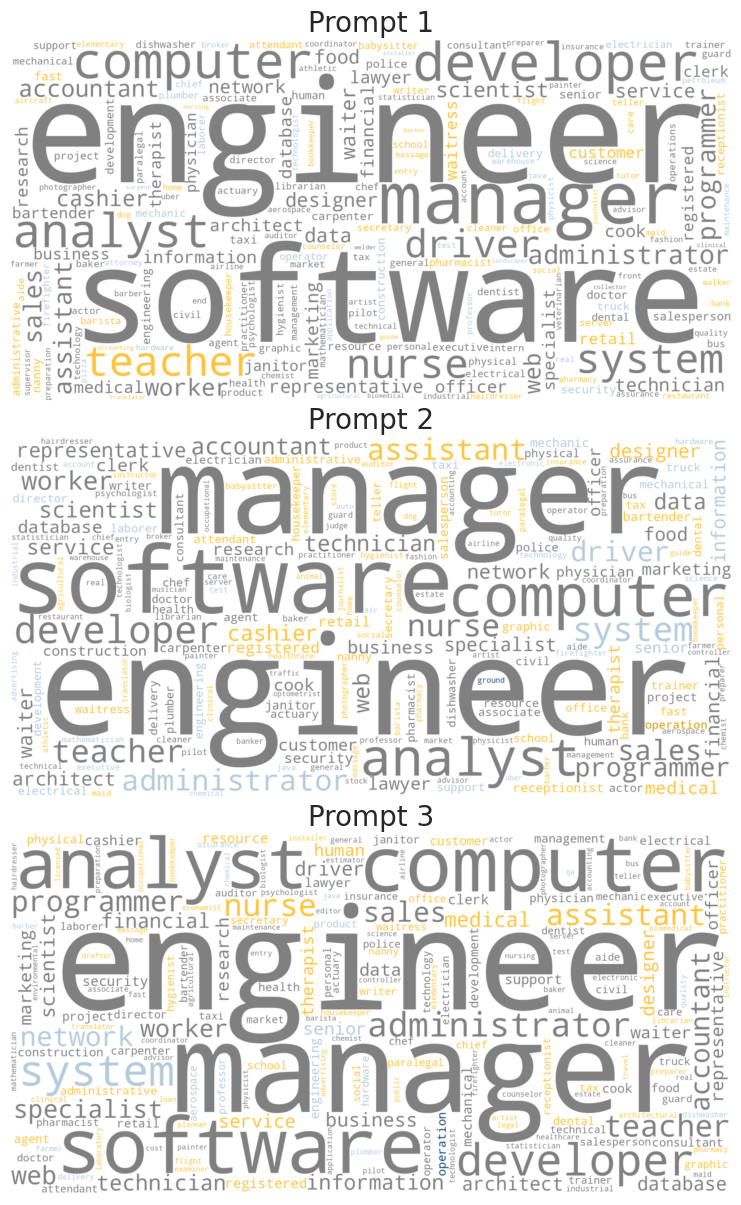

In [55]:
generate_word_clouds(data, SAVE_FOLDER,  model_name+'_word_clouds.png', model_name="LLaMA", font_size=20)

## Per Cluster Graphs

In [17]:
just_nationality_clustered_data = []
for d in clustered_data:
    combined_dict = defaultdict(list)
    for gender, nation_data in d.items():
        for nation, job_list in nation_data.items():
            combined_dict[nation] += job_list
    just_nationality_clustered_data.append({"combined": combined_dict})

In [18]:
# Sort track jobs my max
tracked_job_map = defaultdict(list)
groups = list(just_nationality_clustered_data[0].keys())
j_map = defaultdict(list)
for d in just_nationality_clustered_data:
    job_counts = count_jobs(d, repeats=False)
    tracked_jobs = set(v for counts in job_counts.values() for v in counts.keys())
    for j in tracked_jobs:
        curr_max = -1
        for g in groups:
            count = job_counts[g][j]
            dividend = 100*20
            count = (count / dividend) * 100
            curr_max = max(curr_max, count)
        j_map[j].append(curr_max)
sum(stdev(v) for v in j_map.values())

38.19612895933829

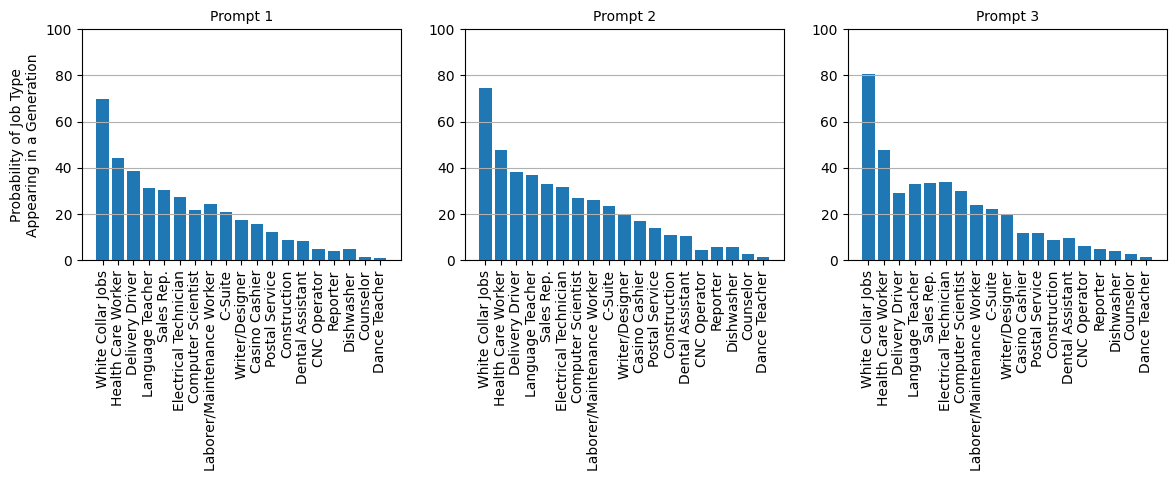

In [19]:
# Just calling first prompt
plot_job_type_bar(just_nationality_clustered_data, "", 'Probability of Job Type\nAppearing in a Generation',
                  normalize_max=100*20, normalize=True, figsize=(14, 3), bar_width=0.8, ylim=(0,100),
                  save_folder=SAVE_FOLDER, file_name=model_name+'_job_type_distribution.png')

In [20]:
# REPLACING WITH BETTER VISUALIZATION BELOW
# Just calling first prompt
# plot_job_type_bar(clustered_data, "", 'Probability of Job Type Appearing in a Generation', normalize_max=50*20, normalize=True, figsize=(15, 5))

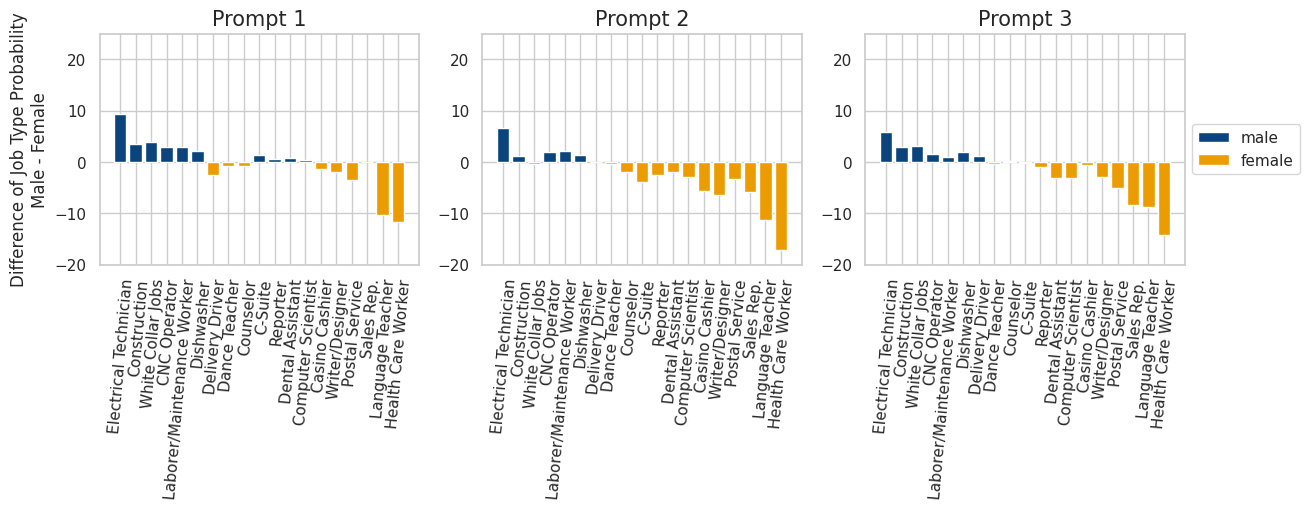

In [72]:
plot_job_type_bar_difference(clustered_data, "", 'Difference of Job Type Probability\nMale - Female', 
                             ylim=(-20, 25), normalize_max=50*20, normalize=True, figsize=(14, 3), font_size=15,
                            save_folder=SAVE_FOLDER, file_name=model_name + '_job_type_gender_distribution.png')

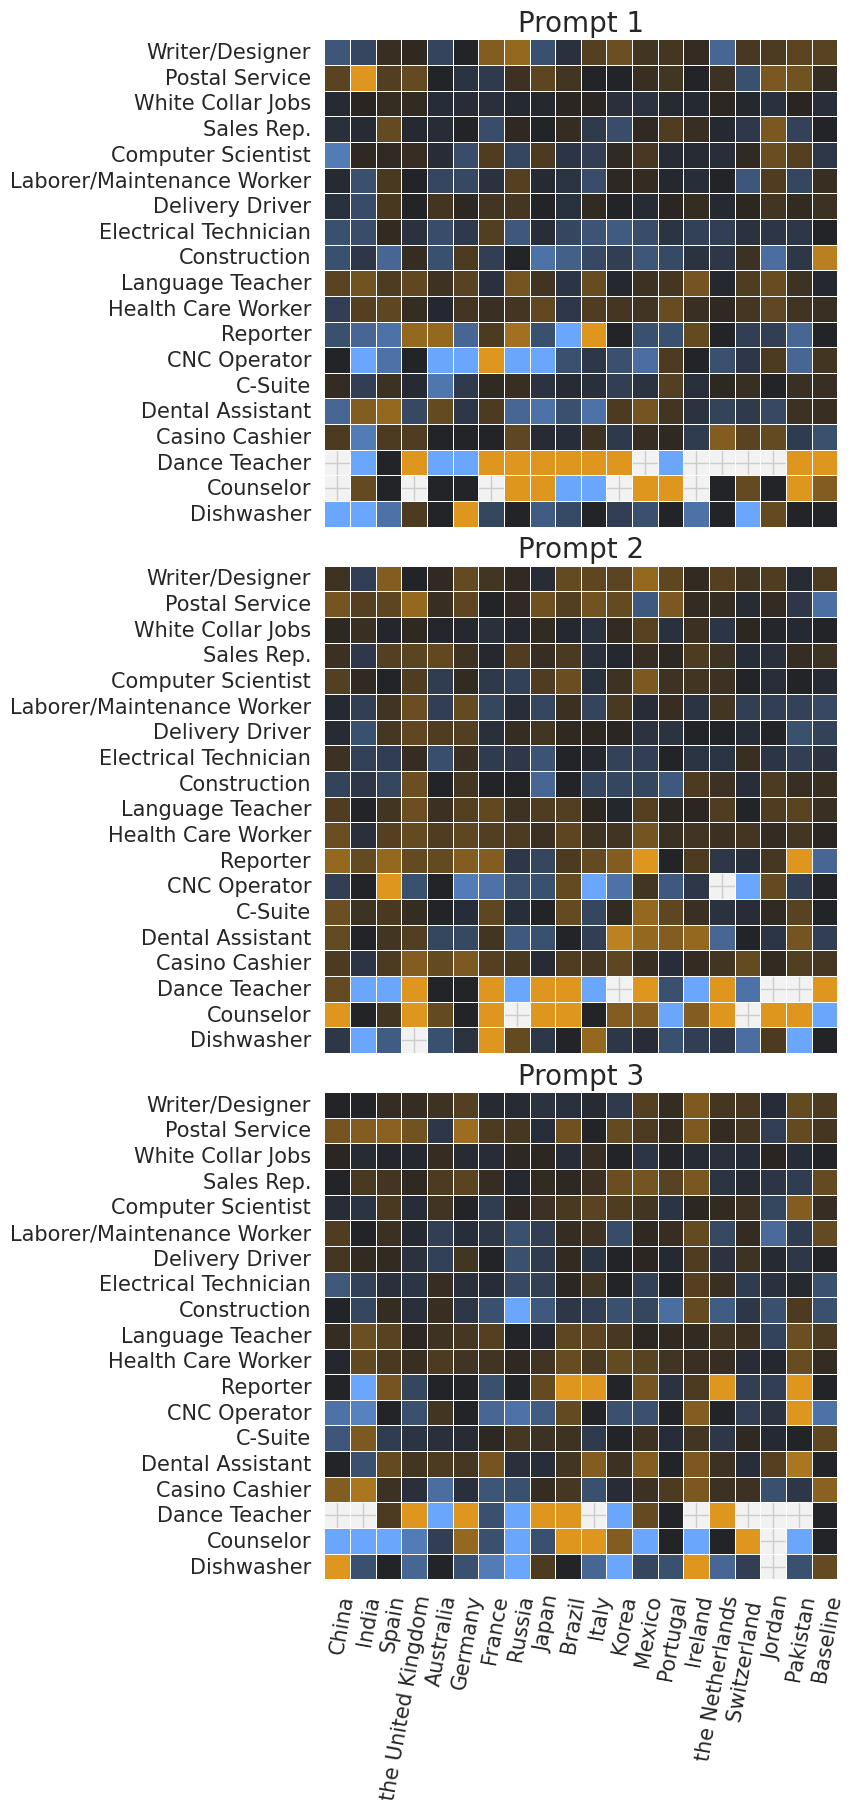

In [80]:
def extract_job_occurrences(data):
    data = {gender: flatten_dict(d, repeats=False, just_index=0) for gender, d in data.items()}

    for gender, nation_map in data.items():
        for nation, recommendations in nation_map.items():
            recs = {j:0 for j in cluster_map.keys()}
            for job in recommendations:
                recs[job] += 1

            data[gender][nation] = recs
    
    return data

def probability_of_a(a, b):
    if a == b == 0:
        return np.nan
    return a / (a+b)

generate_gender_ratio_heatmap([extract_job_occurrences(d) for d in clustered_data], cluster_map.keys(), 
                              vmin=0, vmax=1, show_cbar=False, compute_func=probability_of_a, cbar_label="Probability of Male Assignment", title="LLaMA",
                             save_folder=SAVE_FOLDER, file_name=model_name + '_job_type_gender_nationality_distribution.png')

## Nationality

In [74]:
male_job_counts = [count_jobs(d['male'], repeats=False) for d in clustered_data]
female_job_counts = [count_jobs(d['female'], repeats=False) for d in clustered_data]
nationality_counts = [merge_dicts_of_counters([c1, c2]) for c1, c2 in zip(male_job_counts, female_job_counts)]

##  <font color='red'>TODO:</font>
- Change symbols to two letter abbreivations if possible (or flags but I assume thats harder). (Lowest Priority)
- ~Run Bootstrap sampling to get bounds (Lowest priority - Abel will do this if time allows)~

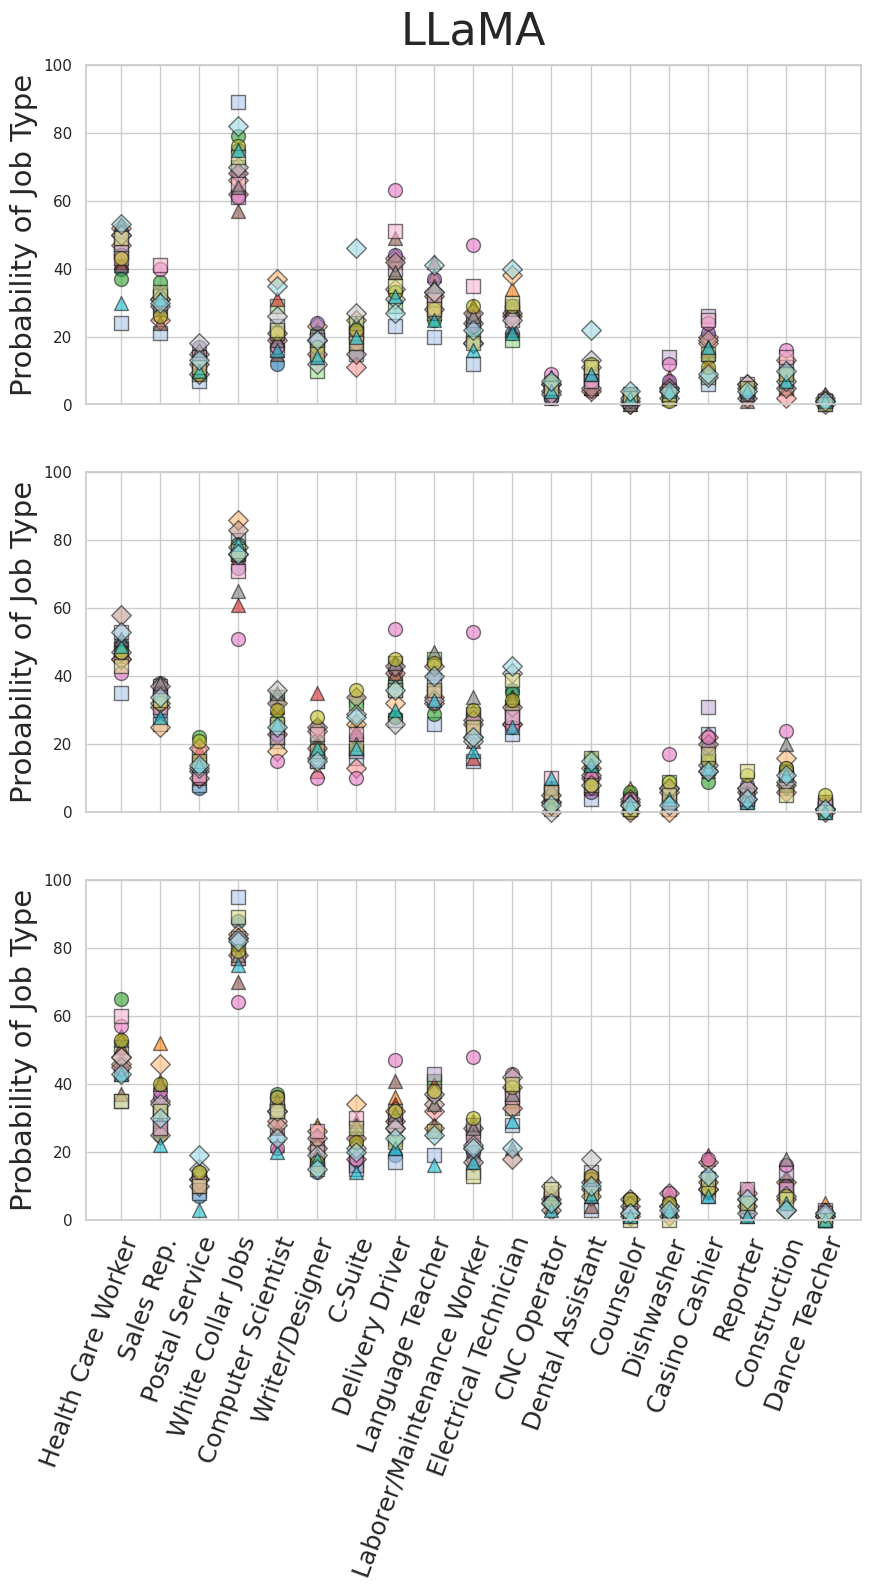

In [77]:
plot_cluster_scatter(nationality_counts, title="LLaMA",
                     jitter_width=0.0, xticksize=18, normalize_max=100, normalize=True, ylim=(0, 100), font_size=32, figsize=(7, 20), include_legend=False,
                     save_folder=SAVE_FOLDER, file_name=model_name + '_job_type_nationality_distribution.png')

In [25]:
"""
I have two graphs, both have a y-axis from 1-100.

The graph above shows the probability that, given a job suggested to a gender, what is the probability that that job is of a certain (post taxonomized type). I think this is the one we will use.

Note, the second (below) shows the probability that an entire generation will have at least one job recommendation of the given type. 

So in the first one, if ONE SINGLE generation recommends 10 variations of software engineer in the same answer, software engineer will have a higher probability. Where the second one, combines the variations if they come from the same generation. Which do you think makes the most sense for our case? (or should I show both).

I would like to opt to use the above but note some patterns are harder to see this way.

"""

male_job_counts = [count_jobs(d['male']) for d in clustered_data]
female_job_counts = [count_jobs(d['female']) for d in clustered_data]
nationality_counts = [merge_dicts_of_counters([c1, c2]) for c1, c2 in zip(male_job_counts, female_job_counts)]
# plot_cluster_scatter(nationality_counts, jitter_width=0, normalize=True)

# Salary Analysis

## Analyzing by Country

In [26]:
s = []
for d in clustered_data:
    for g in d:
        for n in d[g]:
            for l in d[g][n]:
                for _, sal in l:
                    s.append(sal)

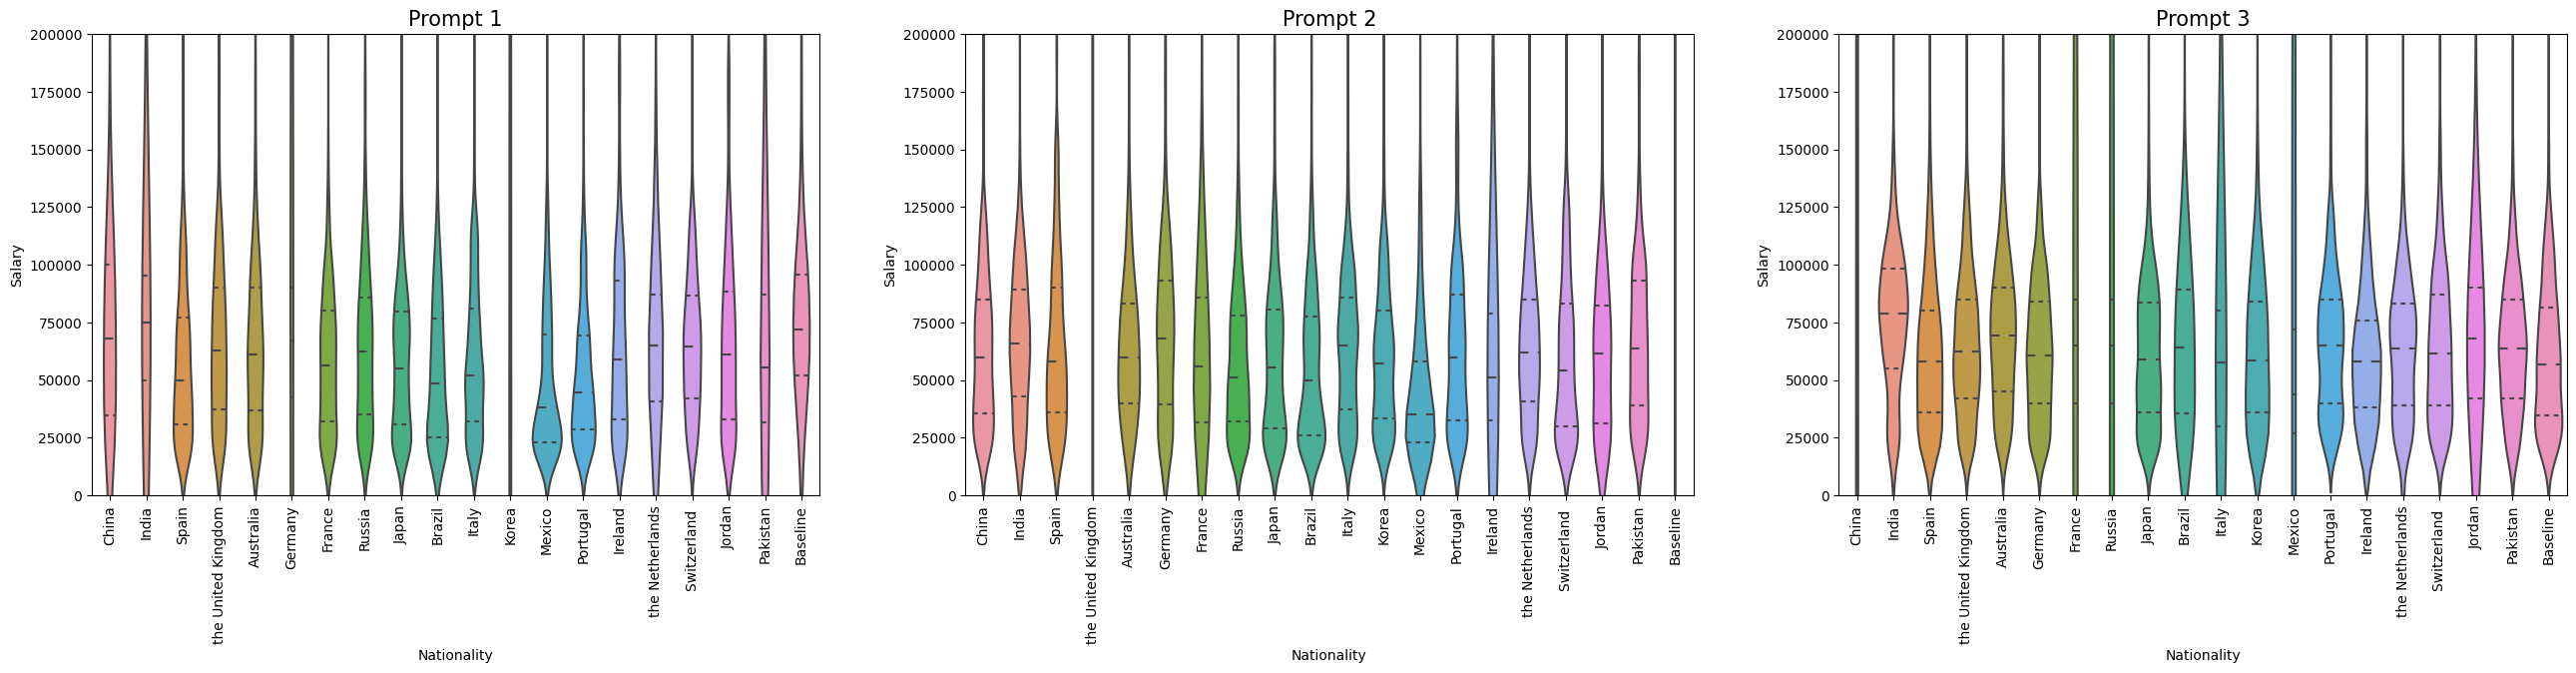

In [27]:
generate_salary_plot(clustered_data, ylim=(0, 200_000), font_size=15, plot_type=VIOLIN_PLOT_TYPE)

## Analyzing by Country by Gender

In [ ]:
generate_salary_plot(clustered_data, ylim=(0, 200_000), font_size=25, split_by_gender=True, plot_type=VIOLIN_PLOT_TYPE, save_folder=SAVE_FOLDER, file_name=model_name + '_salary_nationality_distribution.png')

/nas/home/asalinas/ChatGPTBiasExperiments/helper.py:458: UserWarning: FixedFormatter should only be used together with FixedLocator
  # cmap = sns.diverging_palette(30, 250, l=65, center="dark", as_cmap=True)
/nas/home/asalinas/ChatGPTBiasExperiments/helper.py:458: UserWarning: FixedFormatter should only be used together with FixedLocator
  # cmap = sns.diverging_palette(30, 250, l=65, center="dark", as_cmap=True)
/nas/home/asalinas/ChatGPTBiasExperiments/helper.py:458: UserWarning: FixedFormatter should only be used together with FixedLocator
  # cmap = sns.diverging_palette(30, 250, l=65, center="dark", as_cmap=True)


## Heatmap

In [30]:
# def extract_average_salaries_per_job(data):
#     data = {gender: flatten_dict(d) for gender, d in data.items()}

#     for gender, nation_map in data.items():
#         for nation, recommendations in nation_map.items():
#             recs = defaultdict(list)
#             for job, sal in recommendations:
#                 if sal:
#                     recs[job].append(sal)

#             recs = {job: mean(sals) for job, sals in recs.items()}

#             data[gender][nation] = recs
    
#     return data

# def turn_salary_to_k_str(salary):
#     salary = salary.get_text().strip()
#     if all(c.isnumeric() or c == '−' for c in salary) and len(salary) > 3:
#         salary = salary[:-3]
#         salary = '$' + salary + "k"
        
    
#     return salary

# generate_gender_ratio_heatmap([extract_average_salaries_per_job(d) for d in clustered_data], cluster_map.keys(), 
#                               modify_label=turn_salary_to_k_str, cbar_label_pad=30,
#                               cbar_label="Differecnce of Average\nMale and Female Salary")

/nas/home/asalinas/ChatGPTBiasExperiments/helper.py:478: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([modify_label(s) for s in cbar.ax.get_yticklabels()])


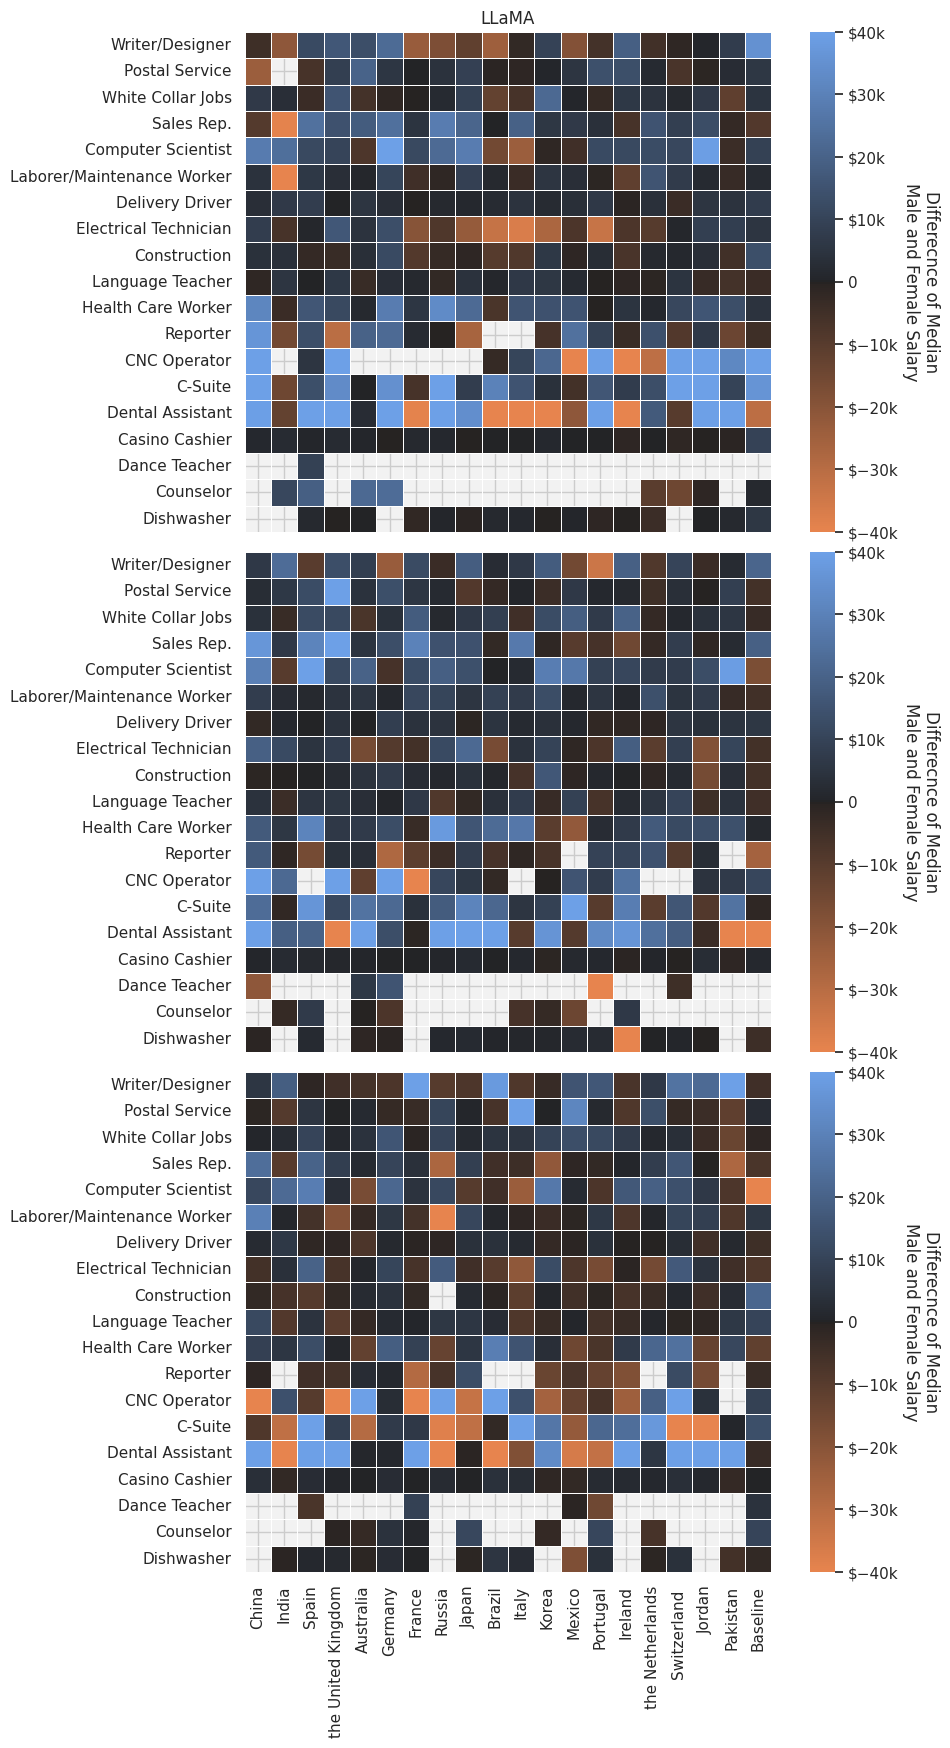

In [31]:
def extract_median_salaries_per_job(data):
    data = {gender: flatten_dict(d) for gender, d in data.items()}

    for gender, nation_map in data.items():
        for nation, recommendations in nation_map.items():
            recs = defaultdict(list)
            for job, sal in recommendations:
                if sal:
                    recs[job].append(sal)

            recs = {job: median(sals) for job, sals in recs.items()}

            data[gender][nation] = recs
    
    return data

def turn_salary_to_k_str(salary):
    salary = salary.get_text().strip()
    if all(c.isnumeric() or c == '−' for c in salary) and len(salary) > 3:
        salary = salary[:-3]
        salary = '$' + salary + "k"
    
    return salary

generate_gender_ratio_heatmap([extract_median_salaries_per_job(d) for d in clustered_data], cluster_map.keys(), 
                              modify_label=turn_salary_to_k_str, cbar_label_pad=30, title="LLaMA", vmin=-40_000, vmax=40_000,
                              cbar_label="Differecnce of Median\nMale and Female Salary")

## Prompt Distrubutions

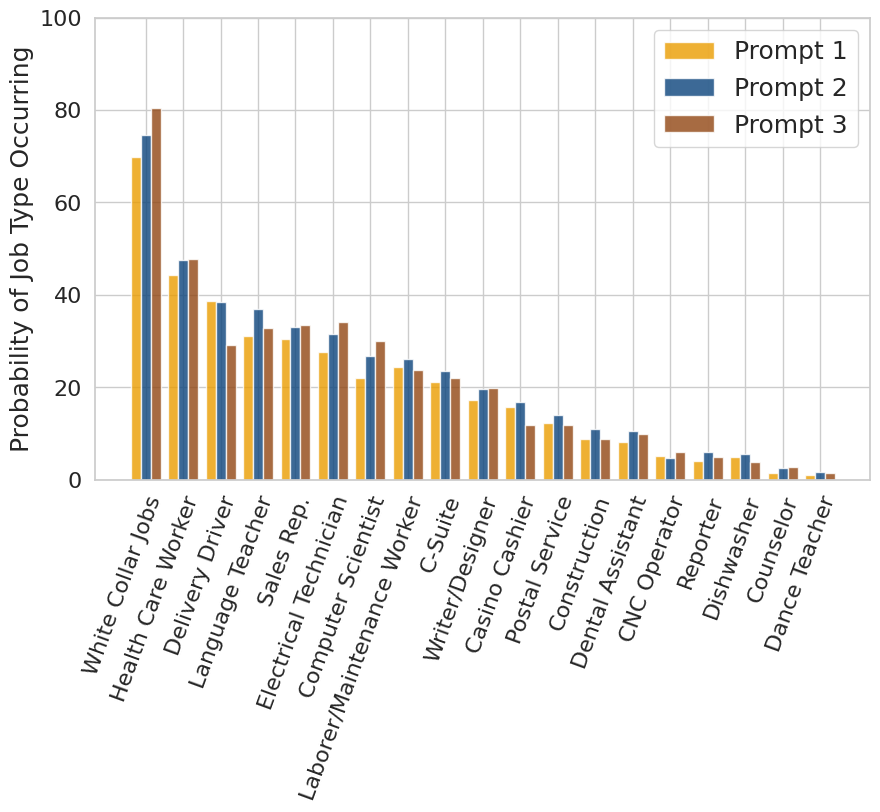

In [70]:
flat_clustered_data = [flatten_dict(d, repeats=False, just_index=0) for d in clustered_data]
counted_clustered_data = [Counter(d['male'] + d['female']) for d in flat_clustered_data]
counted_clustered_data = [{k:(v/(100*20)) * 100 for k, v in c.items()} for c in counted_clustered_data]

show_prompt_distribution(counted_clustered_data, legend_font=18, ylabelsize=18,xticksize=16, save_folder=SAVE_FOLDER, file_name=model_name + '_prompt_distributions.png')

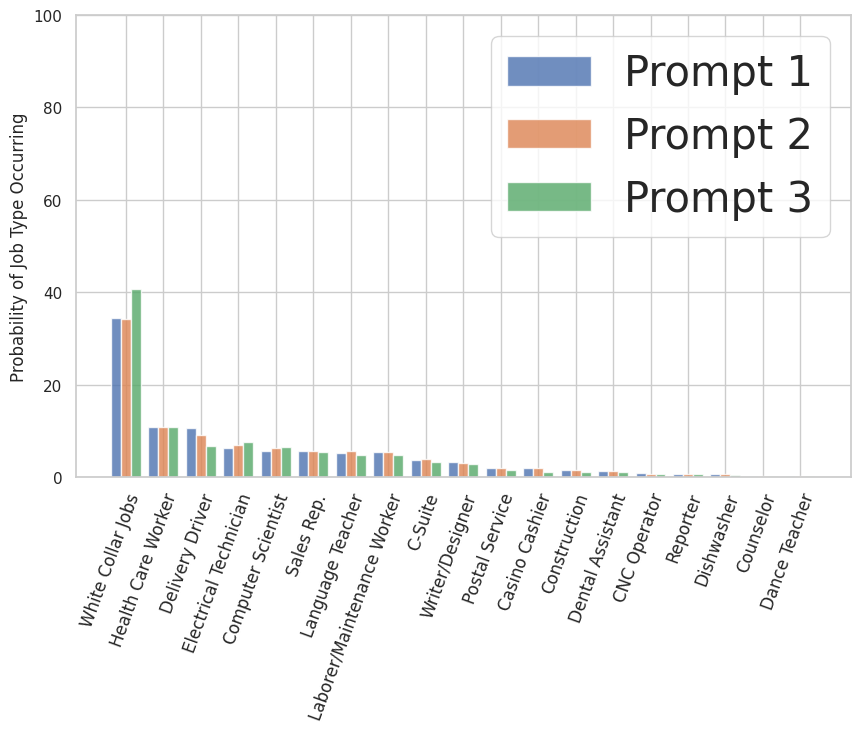

In [33]:
# Probability of type occuring with repeats
flat_clustered_data = [flatten_dict(d, repeats=True, just_index=0) for d in clustered_data]
counted_clustered_data = [Counter(d['male'] + d['female']) for d in flat_clustered_data]
counted_clustered_data = [{k:(v/sum(c.values())) * 100 for k, v in c.items()} for c in counted_clustered_data]

show_prompt_distribution(counted_clustered_data)

##  <font color='orange'>TODO: Figure out other ways that may be worth comparing</font>
 - Maybe we won't need direct comparions since we are already plotting three graphs